# Gradient Boosting

In [2]:
from datetime import datetime
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
import matplotlib.pyplot as plt
import utils
import gb.gb_utils as gb_utils


% matplotlib inline

### Колонки с пропусками
Все эти колонки описывают моменты, которые могли не произойти в первые 5 минут игры.

In [3]:
train_data = utils.get_data(fillna=False)
test_data = utils.get_data(test=True, sample=False)
X_train = train_data.loc[:, train_data.columns != 'radiant_win']
gb_utils.get_skips_df(train_data)

,skips_count
first_blood_time,9764
first_blood_team,9764
first_blood_player1,9764
first_blood_player2,21870
radiant_bottle_time,7961
radiant_courier_time,349
radiant_flying_courier_time,13805
radiant_first_ward_time,918
dire_bottle_time,8192
dire_courier_time,336


### Подготовка данных
В процессе обучения классификатора, я выяснил, что использование среднего значения данных о каждом игроке(золото, опыт и тп.) значительно ускоряет время обучения, а также повышает качество классификации на 5-7%. Однако колонку, содержащую информацию о герое преобразовывать таким способом не имеет смысла, поэтому я прибегнул к методу мешка слов. А также на этом шаге я заменил все nan значения на 0 и удалил колонки, не представляющие никакой важности.

In [4]:
X_train = utils.replace_with_bag_of_words(utils.prepare_data(X_train.fillna(0)))
X_train.head()

,first_blood_team,radiant_bottle_time,radiant_courier_time,radiant_flying_courier_time,radiant_tpscroll_count,radiant_boots_count,radiant_ward_observer_count,radiant_ward_sentry_count,radiant_first_ward_time,dire_bottle_time,...,hero_102,hero_103,hero_104,hero_105,hero_106,hero_107,hero_108,hero_109,hero_110,hero_111
match_id,,,,,,,,,,,,,,,,,,,,,
89025,1.0,105.0,-85.0,243.0,3,4,3,2,22.0,176.0,...,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0,1.0
88779,0.0,134.0,-85.0,269.0,1,4,2,1,-14.0,225.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
90855,0.0,171.0,-86.0,181.0,2,4,3,2,-11.0,145.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
89972,0.0,54.0,-83.0,191.0,4,4,4,1,-11.0,138.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
66798,1.0,66.0,-83.0,213.0,1,3,2,1,-31.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Извлекаем целевую переменную

In [5]:
y = train_data['radiant_win']
y

match_id
89025     0
88779     0
90855     1
89972     0
66798     0
75930     0
72714     1
68289     1
46902     0
42403     1
41029     0
95218     0
73047     1
107001    1
107331    1
95670     1
61908     1
111284    1
265       1
1905      0
103886    1
38836     1
92653     0
56307     1
72368     0
110219    1
69887     0
11631     0
5912      0
67394     1
         ..
42945     1
101131    0
32873     0
69667     0
42744     1
84062     0
15236     1
73655     0
32917     0
7871      1
109387    1
77272     1
57367     0
17502     0
61978     0
45109     1
108860    1
83940     1
21678     0
4114      1
12646     0
13909     1
55837     0
41616     0
82190     0
62884     1
63110     1
98019     1
52994     1
8125      0
Name: radiant_win, Length: 48615, dtype: int64

Обучаем классификатор, используя разные значения для количества деревьев(n_estimators) проводя кросс-валидацию по 5 блокам для оценки качества.

In [6]:
estimators = [10, 20, 30, 70, 120, 250]
scores = []
cross_val_times = []
for n_estimators in estimators:
    cv = KFold(n_splits=5, shuffle=True, random_state=241)
    clf = GradientBoostingClassifier(n_estimators=n_estimators, random_state=241)
    start_time = datetime.now()
    score = cross_val_score(estimator=clf, cv=cv, X=X_train, y=y, scoring='roc_auc').mean()
    cross_val_times.append(datetime.now() - start_time)
    scores.append(score)

Время, которое заняла кросс-валидация по 5 блокам для 30 деревьев:

In [7]:
cross_val_times[estimators.index(30)].total_seconds()

29.985174

Ниже представлен график, показывающий изменение качества классификации с повышением количества деревьев

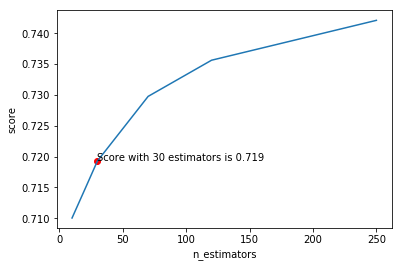

In [8]:
gb_utils.plot(estimators, scores)

Исходя из данных графика, можно заметить, что использование большего количества деревьев влечет за собой повышение качества, а следовательно - есть смысл использовать больше чем 30 деревьев.

# Logistic Regression

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import lr.lr_utils as lr_utils


def train(X, y, scale=True):
  cv = KFold(n_splits=5, shuffle=True, random_state=241)
  X_ = X.copy()
  if scale:
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X_)
  scores = []
  for C in C_range:
    clf = LogisticRegression(C=C, random_state=241)
    score = cross_val_score(estimator=clf, cv=cv, X=X_, y=y, scoring='roc_auc').mean()
    scores.append(score)
  return scores


def train_raw_data(X, y):
  scores = train(X, y)
  lr_utils.plot(C_pows, scores)


def train_data_without_categorical(X, y):
  r_hero_cols, d_hero_cols = utils.get_personal_columns('hero')
  scores = train(X.drop([*r_hero_cols, *d_hero_cols, 'lobby_type'], axis=1), y)
  lr_utils.plot(C_pows, scores)


def train_with_bag_of_words(X, y):
  X = utils.replace_with_bag_of_words(utils.prepare_data(X))
  scores = train(X, y)
  lr_utils.plot(C_pows, scores)

In [10]:
C_pows = range(-5, 1)
C_range = [10.0 ** i for i in C_pows]
train_data = utils.get_data(sample=False)
test_data = utils.get_data(test=True, sample=False)
y = train_data['radiant_win']
X_train = train_data.loc[:, train_data.columns != 'radiant_win']

Значение логистической регрессии на сырых данных оказалось выше, чем у метода градиентного бустинга, при этом скорость заметно выросла

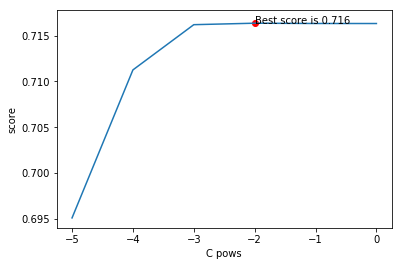

In [11]:
train_raw_data(X_train, y)

Удаление категориальных признаков ни чуть не изменило результат. Лучший счет по прежнему 0.716 и достигается при C = 0.01

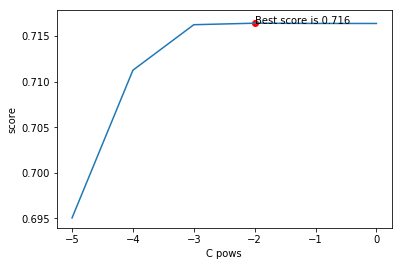

In [12]:
train_data_without_categorical(X_train, y)

Количество уникальных идентификаторов для героев

In [13]:
lr_utils.count_heroes_ids()

112

После добавления мешка слов по героям качество заметно выросло до 0.752

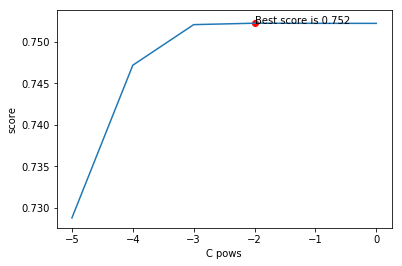

In [14]:
train_with_bag_of_words(X_train, y)

Минимальное значение и максимальное значения предсказаний

In [15]:
X_test = utils.replace_with_bag_of_words(utils.prepare_data(test_data))
clf = LogisticRegression(C=0.01, random_state=241)
clf.fit(utils.replace_with_bag_of_words(utils.prepare_data(X_train)), y)
pred = clf.predict_proba(X_test)[:, 1]
min(pred), max(pred)

(0.0082797737826935738, 0.99582100023691134)